In [1]:
import re
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data = pd.read_csv("Tweets.csv")
df = data[["text","airline_sentiment"]]
df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))


<ipython-input-2-9af2131af9fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))


In [3]:
df

,text,airline_sentiment
0,What @dhepburn said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative
...,...,...
14635,thank you we got on a different flight to Chi...,positive
14636,leaving over 20 minutes Late Flight. No warni...,negative
14637,Please bring American Airlines to #BlackBerry10,neutral
14638,"you have my money, you change my flight, and ...",negative


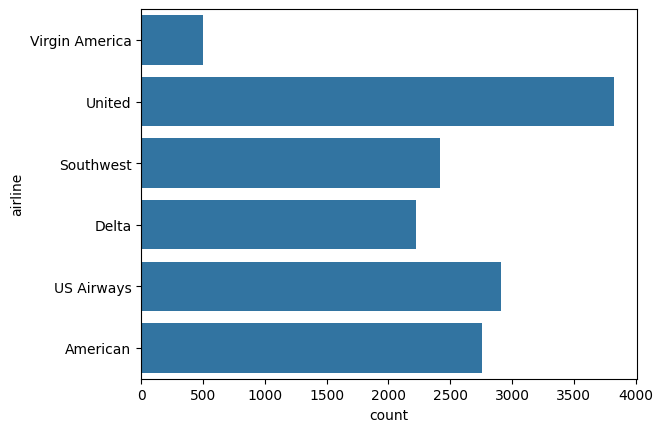

In [4]:
sns.countplot(data.airline);


In [5]:
df = df[df.airline_sentiment!="neutral"] # To remove neutral responses
df['text'] = df['text'].apply(lambda x: x.lower()) # To lower
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # To keep numbers and strings only

<ipython-input-5-2e7e31eb758f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: x.lower()) # To lower
<ipython-input-5-2e7e31eb758f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # To keep numbers and strings only


In [6]:
df.head(5) #Quick Look

,text,airline_sentiment
1,plus youve added commercials to the experienc...,positive
3,its really aggressive to blast obnoxious ente...,negative
4,and its a really big bad thing about it,negative
5,seriously would pay 30 a flight for seats tha...,negative
6,yes nearly every time i fly vx this ear worm ...,positive


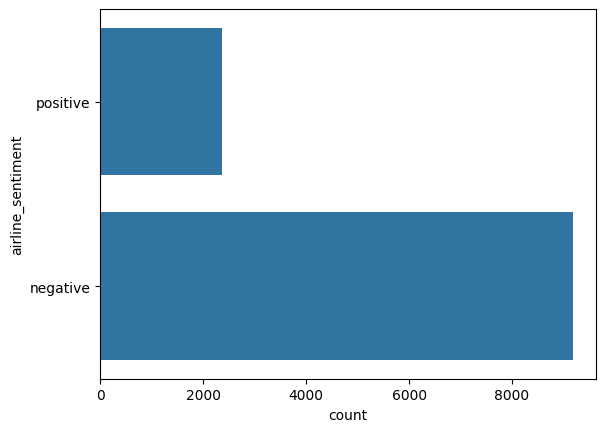

In [7]:
sns.countplot(df.airline_sentiment);#Mostly Negative Reviews(Class Imbalance found)


In [8]:
df = df.drop(df[df.airline_sentiment == "negative"].iloc[:5000].index)

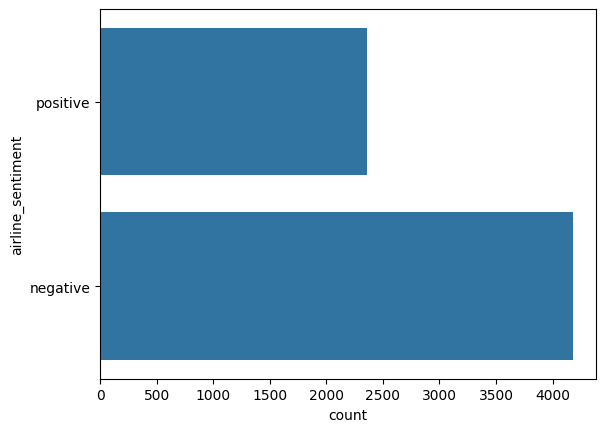

In [9]:
sns.countplot(df.airline_sentiment);

In [10]:
max_fatures = 4000
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)
Y = df['airline_sentiment']
L = Y.values
X
L

array(['positive', 'positive', 'positive', ..., 'positive', 'negative',
       'negative'], dtype=object)

In [11]:
k = []
for i in range(6541):
    if L[i]=="negative":
                        k.append(0)
    elif L[i]=="positive":
                        k.append(1)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, k,
                                                    test_size=0.3,
                                                    shuffle = True,
                                                    stratify = k,
                                                    random_state = 1 )

In [13]:
embed_dim = 128
lstm_out = 196
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(max_fatures, 128, input_length=X_train.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.5))
model.add(tf.keras.layers.LSTM(196, dropout = 0.3, recurrent_dropout = 0.3 ))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(2, activation = tf.nn.softmax))

In [14]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [19]:
import numpy as np

# Convert data to NumPy arrays if needed
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Print out the shapes and types for debugging
print("X_train shape:", X_train.shape, "X_train type:", type(X_train))
print("Y_train shape:", Y_train.shape, "Y_train type:", type(Y_train))

# Now, try fitting your model again
Model = model.fit(X_train,
                  Y_train,
                  epochs=20,
                  batch_size=32,
                  validation_split=0.2)


X_train shape: (4578, 31) X_train type: <class 'numpy.ndarray'>
Y_train shape: (4578,) Y_train type: <class 'numpy.ndarray'>
Epoch 1/20
115/115 [==============================] - 23s 198ms/step - loss: 0.0037 - accuracy: 0.9986 - val_loss: 0.7276 - val_accuracy: 0.9083
Epoch 2/20
115/115 [==============================] - 24s 207ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.6436 - val_accuracy: 0.9127
Epoch 3/20
115/115 [==============================] - 18s 161ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.6003 - val_accuracy: 0.9138
Epoch 4/20
115/115 [==============================] - 17s 151ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.7438 - val_accuracy: 0.9017
Epoch 5/20
115/115 [==============================] - 18s 156ms/step - loss: 0.0016 - accuracy: 0.9986 - val_loss: 0.7293 - val_accuracy: 0.9148
Epoch 6/20
115/115 [==============================] - 19s 160ms/step - loss: 0.0024 - accuracy: 0.9986 - val_loss: 0.7439 - val_accuracy: 0.9061
Epoch

In [21]:
Y_test = np.array(Y_test)
score = model.evaluate(X_test, Y_test, verbose=False)
print("loss = ",score[0])
print("accuracy = ",score[1])


loss =  0.824919581413269
accuracy =  0.903209388256073


62/62 [==============================] - 4s 40ms/step


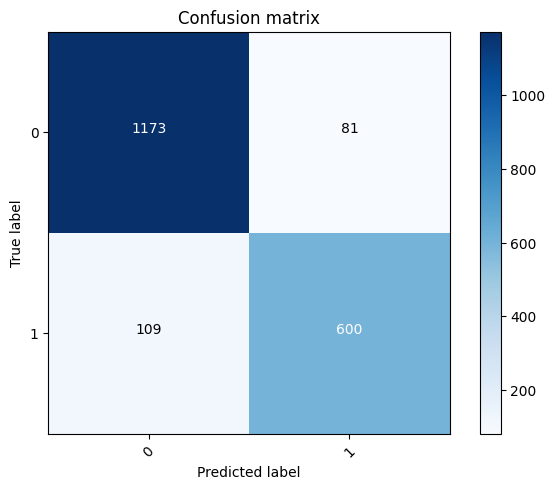

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
confusion_mtx = confusion_matrix(Y_test, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [23]:
sample = ['Meetings: Air crew is so dumb.']
sample = tokenizer.texts_to_sequences(sample)
sample = pad_sequences(sample, maxlen=31, dtype='int32', value=0)
print(sample)
sentiment = model.predict(sample,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 2030  237  147
    11   40 2049]]
1/1 - 0s - 47ms/epoch - 47ms/step
negative
